In [154]:
from __future__ import division
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial
from mayavi import mlab
# mlab.init_notebook()
import glob
from termcolor import colored
import re
import scipy.io as sio
from scipy.interpolate import InterpolatedUnivariateSpline
import shdom

import sys
sys.path.append("../vadim")
from CloudCT_Utils import *

%matplotlib notebook

In [155]:
def plank(llambda,T):
    h = 6.62607004e-34 # Planck constant
    c = 3.0e8
    k = 1.38064852e-23 # Boltzmann constant
    # https://en.wikipedia.org/wiki/Planck%27s_law
    a = 2.0*h*(c**2)
    b = (h*c)/(llambda*k*T)
    spectral_radiance = a/ ( (llambda**5) * (np.exp(b) - 1.0) )
    return spectral_radiance


# mia table parameters:

In [156]:
# mia table parameters:
start_reff = 1
end_reff = 25.0
start_veff = 0.05
end_veff = 0.4
radius_cutoff = 65.0

num_reff = int((end_reff-start_reff)/0.25 + 1)
num_veff = int((end_veff-start_veff)/0.003 + 1)


mie_options = {
    'start_reff': start_reff,# Starting effective radius [Micron]
    'end_reff': end_reff,
    'num_reff': int((end_reff-start_reff)/0.25 + 1),
    'start_veff': start_veff,
    'end_veff': end_veff,
    'num_veff': int((end_veff-start_veff)/0.003 + 1),
    'radius_cutoff': radius_cutoff # The cutoff radius for the pdf averaging [Micron]
}

this_test_dir = '../vadim/spectral_integration_test'
# safe creation of the directory
if not os.path.exists(this_test_dir):
    os.makedirs(this_test_dir)

# wavelengths

In [157]:
"""
The function MieMonodisparse. set_wavelength_integration() sets the wavelength integration parameters to compute a scattering table.
If wavelength_averaging = True, it averages scattering properties over the wavelength band, otherwise (false) it uses scattering properties of the central wavelength.
In addition if wavelength_averaging = True, there is wavelength_resolution parameter that should be set. It is the distance between two wavelength samples in the band.

"""
centeral_wavelength_ = 0.650 # microns
integration_samples = 27
dw = 0.01 # microns
wavelength_integration_samples = np.linspace(centeral_wavelength_-dw, centeral_wavelength_+dw, integration_samples+1)
integration_samples = integration_samples + 1

temp = 5800 #K
spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wavelength_integration_samples,temp) # units fo W/(m^2 nm) ,
L_TOA = spectral_radiance_black_body


# Calculate phase tables for central wavelength usage

In [158]:
# safe creation of the directory
mono_directory = os.path.join(this_test_dir,'monodisperse')
if not os.path.exists(mono_directory):
    os.makedirs(mono_directory)

poly_directory = os.path.join(this_test_dir,'polydisperse')
if not os.path.exists(poly_directory):
    os.makedirs(poly_directory)
    
    
    
for central_wavelength in wavelength_integration_samples:
    
    central_wavelength = shdom.float_round(central_wavelength)
    
    # Create a monodisperse Mie scattering table for a set wavelength as a function of radius.
    mie_mono = shdom.MieMonodisperse(particle_type='Water')
    mie_mono.set_wavelength_integration(wavelength_band=(central_wavelength, central_wavelength))   
    mie_mono.set_radius_integration(minimum_effective_radius=start_reff, max_integration_radius=radius_cutoff)
    mie_mono.compute_table()
    # save to mono dir
    output_path = os.path.join(mono_directory, 'Water_{}nm.scat'.format(int(1e3*central_wavelength)))
    mie_mono.write_table(output_path)
    
    # Compute a size distribution and plot for several size distribution parameters
    size_distribution = shdom.SizeDistribution(type='gamma')
    size_distribution.set_parameters(reff=np.linspace(start_reff, end_reff, num_reff), veff=np.linspace(start_veff, end_veff, num_veff))
    size_distribution.compute_nd(radii=mie_mono.radii, particle_density=mie_mono.pardens)

    # Compute Polydisperse scattering for multiple size-distributions and save a polydisperse table.
    mie_poly = shdom.MiePolydisperse(
    mono_disperse=mie_mono, 
    size_distribution=size_distribution
    )
    mie_poly.compute_table()
    
    output_path = os.path.join(poly_directory, 'Water_{}nm.scat'.format(int(1e3*central_wavelength)))
    mie_poly.write_table(output_path)

Writing Mie monodisperse table to file: ../vadim/spectral_integration_test/monodisperse/Water_640nm.scat
Writing mie table to file: ../vadim/spectral_integration_test/polydisperse/Water_640nm.scat
Writing Mie monodisperse table to file: ../vadim/spectral_integration_test/monodisperse/Water_641nm.scat
Writing mie table to file: ../vadim/spectral_integration_test/polydisperse/Water_641nm.scat
Writing Mie monodisperse table to file: ../vadim/spectral_integration_test/monodisperse/Water_641nm.scat
Writing mie table to file: ../vadim/spectral_integration_test/polydisperse/Water_641nm.scat
Writing Mie monodisperse table to file: ../vadim/spectral_integration_test/monodisperse/Water_642nm.scat
Writing mie table to file: ../vadim/spectral_integration_test/polydisperse/Water_642nm.scat
Writing Mie monodisperse table to file: ../vadim/spectral_integration_test/monodisperse/Water_643nm.scat
Writing mie table to file: ../vadim/spectral_integration_test/polydisperse/Water_643nm.scat
Writing Mie mon

# Calculate phase table for spectral average over the wavelength range

In [159]:
mie_mono = shdom.MieMonodisperse(particle_type='Water')
mie_mono.set_wavelength_integration(wavelength_band=(wavelength_integration_samples[0], wavelength_integration_samples[-1])
                                   ,wavelength_averaging=True,wavelength_resolution=dw)

mie_mono.set_radius_integration(minimum_effective_radius=start_reff, max_integration_radius=radius_cutoff)
mie_mono.compute_table()
# save to mono dir
output_path = os.path.join(mono_directory, 'averaged_Water_{}nm.scat'.format(int(1e3*centeral_wavelength_)))
mie_mono.write_table(output_path)

# Compute a size distribution and plot for several size distribution parameters
size_distribution = shdom.SizeDistribution(type='gamma')
size_distribution.set_parameters(reff=np.linspace(start_reff, end_reff, num_reff), veff=np.linspace(start_veff, end_veff, num_veff))
size_distribution.compute_nd(radii=mie_mono.radii, particle_density=mie_mono.pardens)

# Compute Polydisperse scattering for multiple size-distributions and save a polydisperse table.
mie_poly = shdom.MiePolydisperse(
mono_disperse=mie_mono, 
size_distribution=size_distribution
)
mie_poly.compute_table()
output_path = os.path.join(poly_directory, 'averaged_Water_{}nm.scat'.format(int(1e3*centeral_wavelength_)))
mie_poly.write_table(output_path)

Writing Mie monodisperse table to file: ../vadim/spectral_integration_test/monodisperse/averaged_Water_650nm.scat
Writing mie table to file: ../vadim/spectral_integration_test/polydisperse/averaged_Water_650nm.scat


# Simulation parameters:

<IPython.core.display.Javascript object>


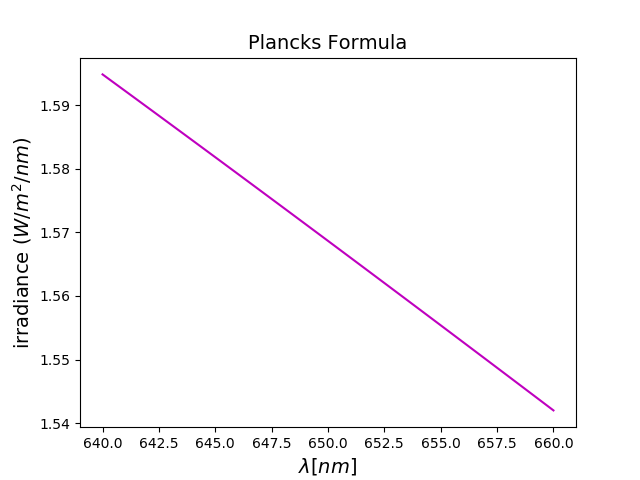

Text(0, 0.5, 'irradiance ($W/m^2/nm$)')

In [160]:
sun_zenith = 180
Cosain = np.cos(np.deg2rad((180-sun_zenith)))
solar_fluxs = 1*np.ones_like(L_TOA) # later scale it by Cosain*L_TOA
scale_solar_fluxs = Cosain*L_TOA

# plot what is in the spectral band:
plt.figure()
plt.plot(wavelength_integration_samples*1e3,scale_solar_fluxs,color = 'm',label = 'black body at {}K'.format(temp))
plt.title("Plancks Formula", fontsize=14)
plt.xlabel("$\lambda [nm]$", fontsize=14)# sinse x axis is wavelengths*1e3
plt.ylabel("irradiance ($W/m^2/nm$)", fontsize=14)


# Set medium per wavelength 

In [161]:
air_path = '../ancillary_data/AFGL_summer_mid_lat.txt' # Path to csv file which contains temperature measurements
air_num_points = 20 # Number of altitude grid points for the air volume
air_max_alt = 5 # in km ,Maximum altitude for the air volume

# Generate multi-spectral scatterers for both droplets and air molecules
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico32x37x26.txt', veff=0.1)
# droplets.load_from_csv('ZeroAtm100x100x10.txt', veff=0.1)

air = shdom.MultispectralScatterer()

# Rayleigh scattering for air molecules
df = pd.read_csv(air_path, comment='#', sep=' ')
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, air_max_alt, air_num_points))

for central_wavelength in wavelength_integration_samples:
    central_wavelength = shdom.float_round(central_wavelength)
    table_path = os.path.join(poly_directory, 'Water_{}nm.scat'.format(int(1e3*central_wavelength)))
    
    # Molecular Rayleigh scattering
    rayleigh = shdom.Rayleigh(central_wavelength)
    rayleigh.set_profile(temperature_profile.resample(air_grid))
    air.add_scatterer(rayleigh.get_scatterer())
    
    # Droplet Mie scattering
    mie = shdom.MiePolydisperse()
    mie.read_table(table_path)
    droplets.add_mie(mie)
    print(mie.wavelength)
    # here droplets.num_wavelengths = air.num_wavelengths = wavelength_num
    
    
# Generate an atmospheric medium with both scatterers
atmospheric_grid = droplets.grid + air.grid
# atmospheric_grid = droplets.grid
atmosphere = shdom.Medium(atmospheric_grid)
atmosphere.add_scatterer(droplets, name='cloud')
atmosphere.add_scatterer(air, name='air')


Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_640nm.scat
0.64
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_641nm.scat
0.641
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_641nm.scat
0.641
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_642nm.scat
0.642
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_643nm.scat
0.643
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_644nm.scat
0.644
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_644nm.scat
0.644
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_645nm.scat
0.645
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_646nm.scat
0.646
Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/Water_647nm.scat
0.647
R

# Set RTE solver

In [162]:
# Generate a solver array for a multispectral solution
rte_solvers = shdom.RteSolverArray()
"""
Parallel solving of all solvers.
        
        Main solver routine. This routine is comprised of two parts:
          1. Initialization (init_solution method), optional
          2. Parallel solution iterations (solution_iterations method followed by update_solution_arguments method)
"""
split_accuracy = 0.1
for central_wavelength,flux in zip(wavelength_integration_samples,solar_fluxs):
    central_wavelength = shdom.float_round(central_wavelength)
    

    numerical_params = shdom.NumericalParameters(num_mu_bins=16,num_phi_bins=32,
                                                 split_accuracy=split_accuracy,max_total_mb=500000.0)
    
    scene_params = shdom.SceneParameters(
        wavelength=central_wavelength,
        surface=shdom.LambertianSurface(albedo=0.05),
        source=shdom.SolarSource(azimuth=0, zenith=sun_zenith,flux=1) # flux=solar_flux
    ) 
    rte_solver = shdom.RteSolver(scene_params, numerical_params)
    rte_solver.set_medium(atmosphere)
    rte_solvers.add_solver(rte_solver)

 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--
 --rte:init_memory--


# Solve RTE

In [163]:
"""
Solve the Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure (shdomsub1.f).
The outputs are the source function (J) and radiance field (I) which are stored in 
the shdom.RteSolver object. These are subsequently used for the rendering of an image.
"""
rte_solvers.solve(maxiter=100)

 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--
 --rte:init_solution--


# Render one perspective view

In [164]:
# A Perspective trasnormation (pinhole camera).
    
dx = atmospheric_grid.dx
dy = atmospheric_grid.dy

nz = atmospheric_grid.nz
nx = atmospheric_grid.nx
ny = atmospheric_grid.ny

Lx = atmospheric_grid.bounding_box.xmax - atmospheric_grid.bounding_box.xmin
Ly = atmospheric_grid.bounding_box.ymax - atmospheric_grid.bounding_box.ymin
Lz = atmospheric_grid.bounding_box.zmax - atmospheric_grid.bounding_box.zmin
L = max(Lx,Ly)
dz = Lz/nz


Rsat = 500 # km
fov = 2*np.rad2deg(np.arctan(0.5*L/(Rsat)))
sc = 4
cny= sc*ny
cnx = sc*nx

origin = [0.5*nx*dx , 0.5*ny*dy , Rsat]
lookat = [0.5*nx*dx , 0.5*ny*dy , 0]

# render 1 views and see the camera x,y,z , angles:
x, y, z = origin
proj = shdom.PerspectiveProjection(fov, cnx, cny, x, y, z)
proj.look_at_transform(lookat,[0,1,0])

camera = shdom.Camera(shdom.RadianceSensor(), proj)
images = camera.render(rte_solvers, n_jobs=20)

# calculate images maximum:
images_array = np.array(images)
MAXI = images_array.max()

# save rendered images:
file_name = 'UNITY_FLUX_VIS_range'+'.mat'
sio.savemat(file_name, {'imgs':images,'maximum':MAXI})

(948,)
(947,)
(948,)
(947,)
(948,)
(948,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(948,)
(948,)
(947,)
(947,)
(947,)
(948,)
(947,)
(948,)
(947,)
(947,)
(947,)
(947,)
(947,)(947,)

(947,)
(947,)
(948,)
(947,)
(947,)
(948,)
(947,)
(948,)
(947,)
(947,)
(947,)(947,)

(947,)
(947,)
(948,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(948,)
(947,)
(947,)
(947,)
(948,)
(948,)
(947,)
(947,)
(947,)
(948,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)(947,)

(947,)
(947,)
(948,)
(947,)
(947,)
(947,)
(947,)
(948,)
(948,)
(947,)
(947,)
(947,)
(947,)
(948,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(948,)
(948,)
(947,)
(948,)
(947,)
(947,)
(947,)
(947,)(948,)

(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(948,)
(947,)
(947,)
(947,)
(948,)(947,)
(947,)

(947,)
(947,)
(948,)
(948,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(948,)
(947,)
(948,)
(947,)(947,)

(948,)
(947,)
(947,)
(948,)
(947,)

# Integrate over spectral band

<IPython.core.display.Javascript object>


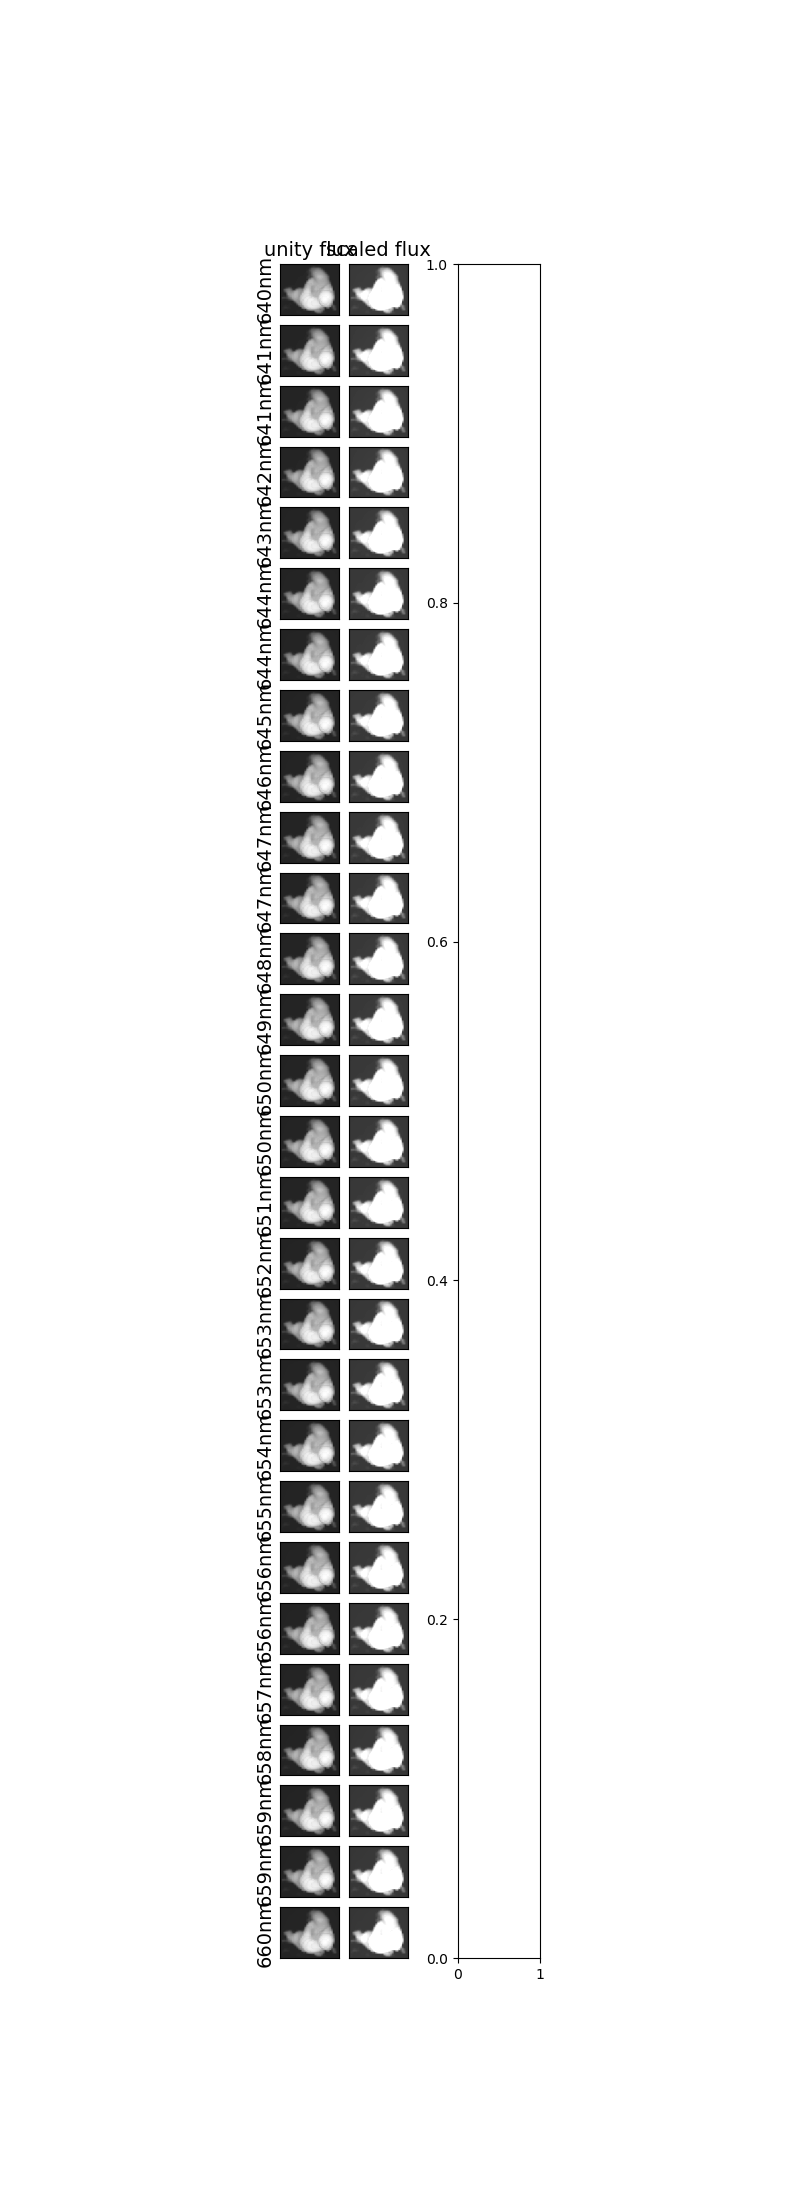

0.21319497
0.21410942
0.2138509
0.21307752
0.21561338
0.21545956
0.21519646
0.2167865
0.21554686
0.21315302
0.21288991
0.21195936
0.21182804
0.21219036
0.21192569
0.21056676
0.21182789
0.21125537
0.21098918
0.21132518
0.21021494
0.21070516
0.21043706
0.20828655
0.21062648
0.20916551
0.20889682
0.20840211


In [176]:
# integrated_image = 
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable


scaled_images = images.copy()

fontsize = 14
fig = plt.figure(figsize=(8, 22))
grid = AxesGrid(fig, 111,
                nrows_ncols=(integration_samples, 2),
                axes_pad=0.1,share_all=True,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.5
                )
ax_ind = 0

grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
    
unity_title = 'unity flux'
scaled_title = 'scaled flux'


for img_inx, (central_wavelength,scale_solar_flux) in enumerate(zip(wavelength_integration_samples,scale_solar_fluxs)):
    central_wavelength = shdom.float_round(central_wavelength)
    
    ax = grid[ax_ind]
    im = ax.imshow(images[:,:,img_inx],cmap='gray',vmin=0, vmax=images[:,:,img_inx].max())
    ax.set_ylabel('{}nm'.format(int(1e3*central_wavelength)),rotation=90, fontsize=fontsize)
    if(ax_ind == 0):
        ax.set_title(unity_title, fontsize=fontsize)
        
    ax = grid[ax_ind+1]
    scaled_images[:,:,img_inx] = scale_solar_flux*images[:,:,img_inx]
#     print('befor scaling {}\n, scale {}\n, after scaling {}\n'.format(images[:,:,img_inx].max(),scale_solar_flux,scaled_images[:,:,img_inx].max()))
    print(scaled_images[:,:,img_inx].max())
    
    im = ax.imshow(scale_solar_flux*images[:,:,img_inx],cmap='gray',vmin=0, vmax=images[:,:,img_inx].max())
    if(ax_ind == 0):
        ax.set_title(scaled_title, fontsize=fontsize)   
     
    
    ax_ind = ax_ind + 2
    
    
    






<IPython.core.display.Javascript object>


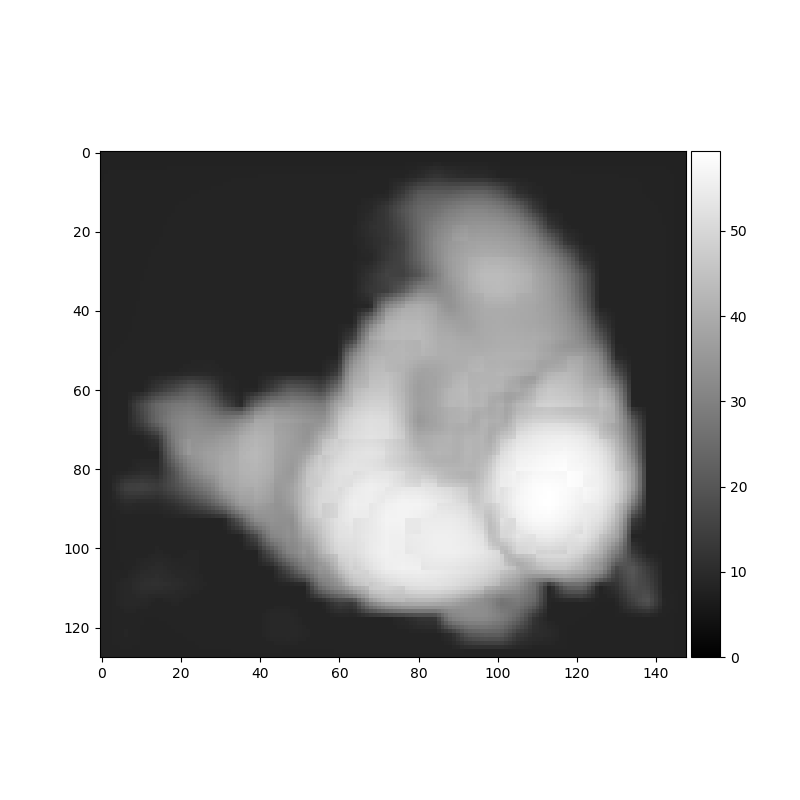

In [166]:
# integration:
total_image = (dw*1e3)*np.sum(scaled_images, axis = 2) # x is in nu
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

im = plt.imshow(total_image,cmap='gray',vmin=0, vmax=total_image.max())

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


# Take cake of the avareged option

In [167]:

# Generate multi-spectral scatterers for both droplets and air molecules
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico32x37x26.txt', veff=0.1)
# droplets.load_from_csv('ZeroAtm100x100x10.txt', veff=0.1)

air = shdom.MultispectralScatterer()

# Rayleigh scattering for air molecules
df = pd.read_csv(air_path, comment='#', sep=' ')
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, air_max_alt, air_num_points))


table_path = os.path.join(poly_directory, 'averaged_Water_{}nm.scat'.format(int(1e3*centeral_wavelength_)))

# Molecular Rayleigh scattering
rayleigh = shdom.Rayleigh(centeral_wavelength_)
rayleigh.set_profile(temperature_profile.resample(air_grid))
air.add_scatterer(rayleigh.get_scatterer())

# Droplet Mie scattering
mie = shdom.MiePolydisperse()
mie.read_table(table_path)
droplets.add_mie(mie)
print(mie.wavelength)
# here droplets.num_wavelengths = air.num_wavelengths = wavelength_num

    
# Generate an atmospheric medium with both scatterers
atmospheric_grid = droplets.grid + air.grid
# atmospheric_grid = droplets.grid
atmosphere = shdom.Medium(atmospheric_grid)
atmosphere.add_scatterer(droplets, name='cloud')
atmosphere.add_scatterer(air, name='air')

Reading mie table from file: ../vadim/spectral_integration_test/polydisperse/averaged_Water_650nm.scat
0.65


In [168]:

split_accuracy = 0.1
numerical_params = shdom.NumericalParameters(num_mu_bins=16,num_phi_bins=32,
                                             split_accuracy=split_accuracy,max_total_mb=500000.0)

scene_params = shdom.SceneParameters(
    wavelength=centeral_wavelength_,
    surface=shdom.LambertianSurface(albedo=0.05),
    source=shdom.SolarSource(azimuth=0, zenith=sun_zenith,flux=1) # flux=solar_flux
) 
rte_solver = shdom.RteSolver(scene_params, numerical_params)
rte_solver.set_medium(atmosphere)


rte_solver.solve(maxiter=100)

 --rte:init_memory--
 --rte:solve--
 --rte:init_solution--


In [169]:
proj = shdom.PerspectiveProjection(fov, cnx, cny, x, y, z)
proj.look_at_transform(lookat,[0,1,0])
camera = shdom.Camera(shdom.RadianceSensor(), proj)
averaged_image = camera.render(rte_solver, n_jobs=20)



(948,)
(948,)
(947,)
(948,)
(948,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)
(947,)


# Integrate over spectral band with the avareged optical parameters rendered image

<IPython.core.display.Javascript object>


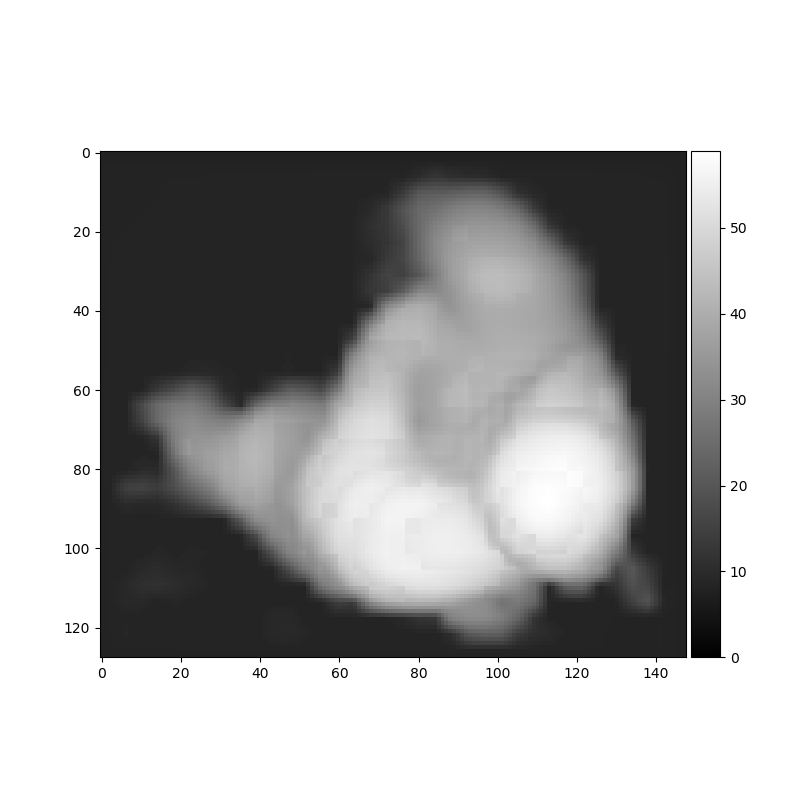

In [170]:
# integration:
total_image_from_avareged = averaged_image*(dw*1e3)*np.sum(scale_solar_fluxs) # x is in nu
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

im = plt.imshow(total_image_from_avareged,cmap='gray',vmin=0, vmax=total_image_from_avareged.max())

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

<IPython.core.display.Javascript object>


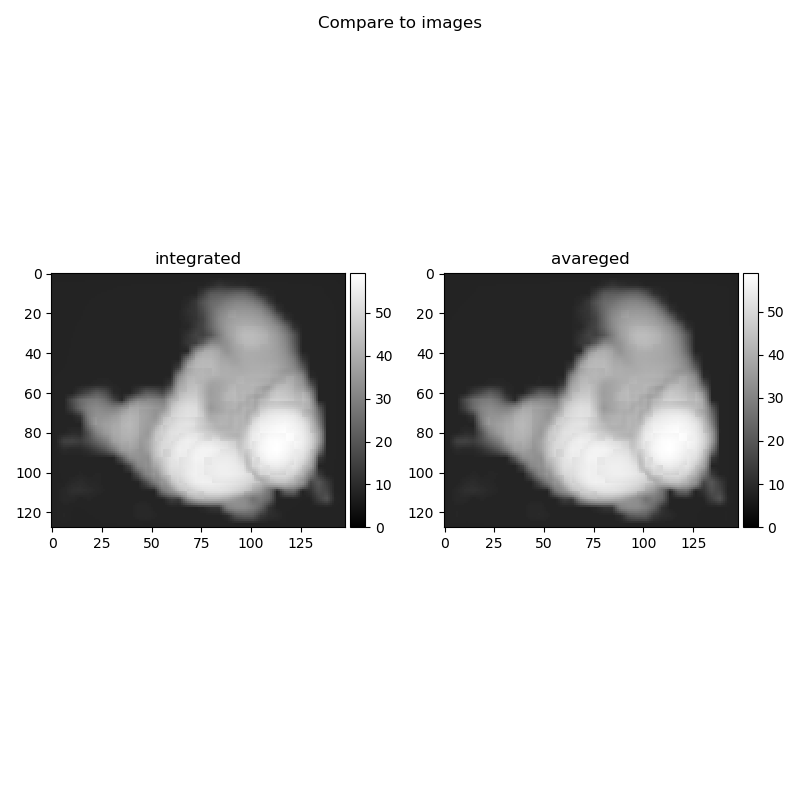

In [174]:
fig, grid = plt.subplots(1, 2, figsize=(8, 8))  
fig.suptitle("Compare to images")

main_ax_left = grid[0]
main_ax_rigth = grid[1]

title_left = "integrated"
main_ax_left.set_title(title_left)

title_rigth = "avareged"
main_ax_rigth.set_title(title_rigth)

im_left = main_ax_left.imshow(total_image,cmap='gray',vmin=0, vmax=total_image.max())
im_rigth = main_ax_rigth.imshow(total_image_from_avareged,cmap='gray',vmin=0, vmax=total_image_from_avareged.max())

divider = make_axes_locatable(main_ax_rigth)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_rigth, cax=cax)

divider = make_axes_locatable(main_ax_left)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_left, cax=cax)

fig.tight_layout()

<IPython.core.display.Javascript object>


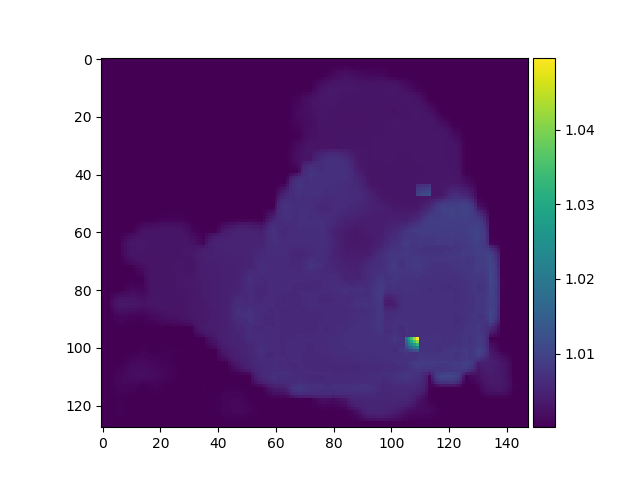

In [172]:
ration = total_image/total_image_from_avareged

plt.figure()
ax = plt.gca()
im = ax.imshow(ration)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

In [175]:

max_reach_lens = scaled_images.max(axis=0).max(axis=0)
max_reach_lens

array([0.21319497, 0.21410942, 0.2138509 , 0.21307752, 0.21561338,
       0.21545956, 0.21519646, 0.2167865 , 0.21554686, 0.21315302,
       0.21288991, 0.21195936, 0.21182804, 0.21219036, 0.21192569,
       0.21056676, 0.21182789, 0.21125537, 0.21098918, 0.21132518,
       0.21021494, 0.21070516, 0.21043706, 0.20828655, 0.21062648,
       0.20916551, 0.20889682, 0.20840211], dtype=float32)

# Calculate the reflection

<IPython.core.display.Javascript object>


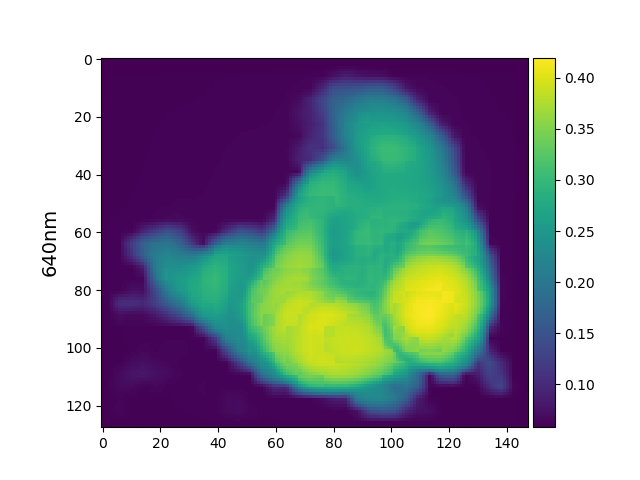

<IPython.core.display.Javascript object>


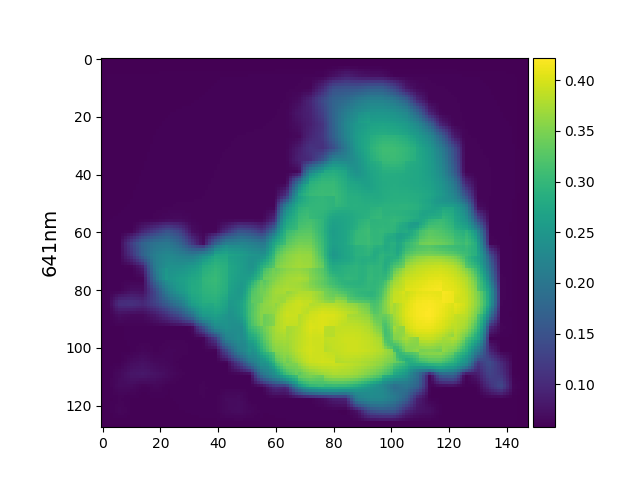

<IPython.core.display.Javascript object>


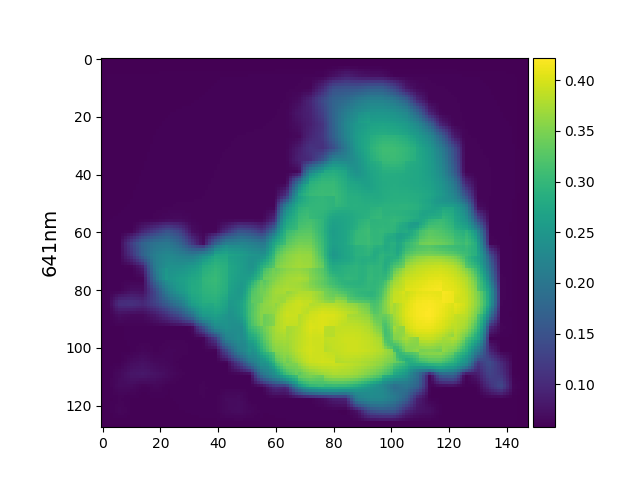

<IPython.core.display.Javascript object>


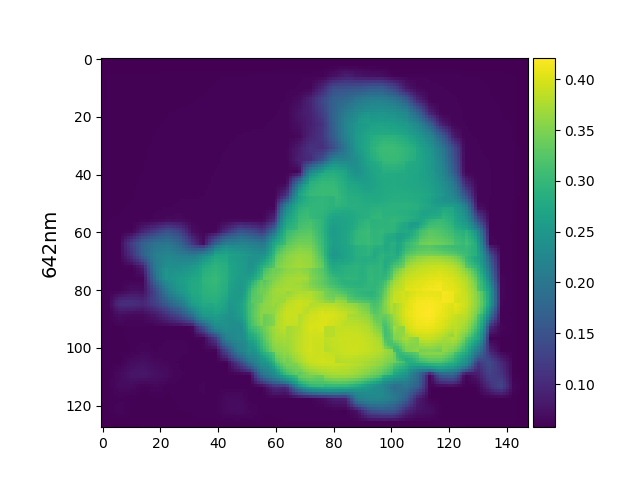

<IPython.core.display.Javascript object>


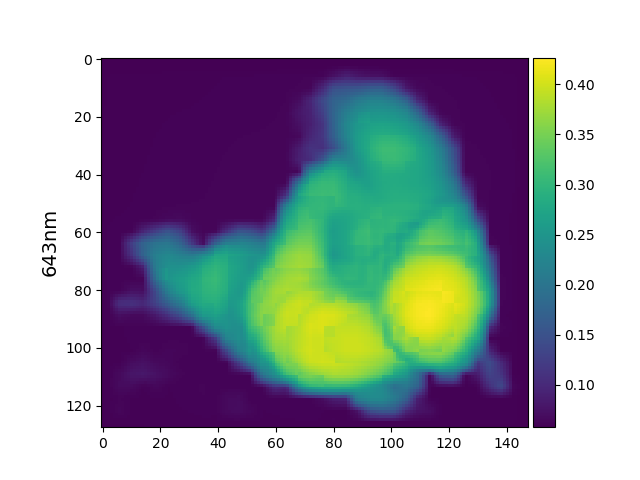

<IPython.core.display.Javascript object>


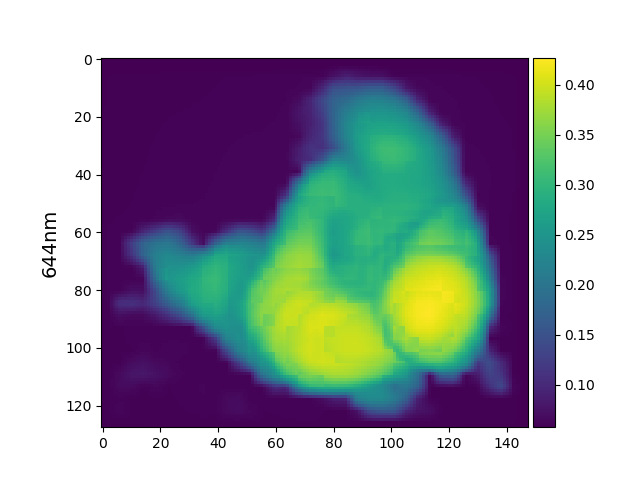

<IPython.core.display.Javascript object>


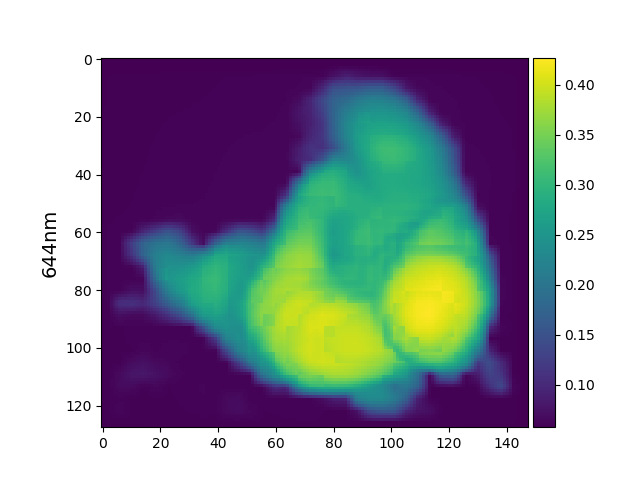

<IPython.core.display.Javascript object>


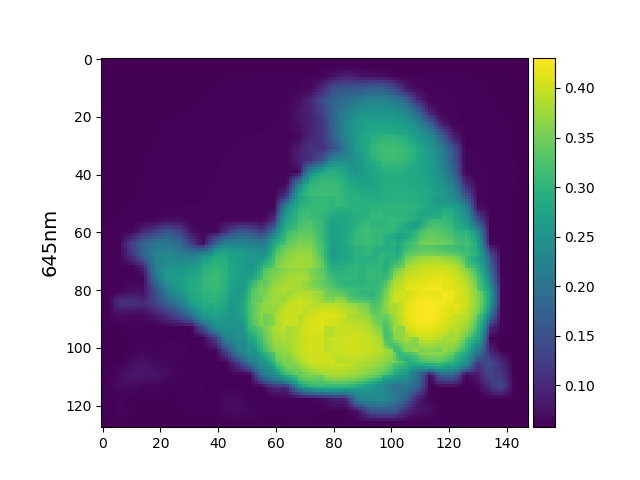

<IPython.core.display.Javascript object>


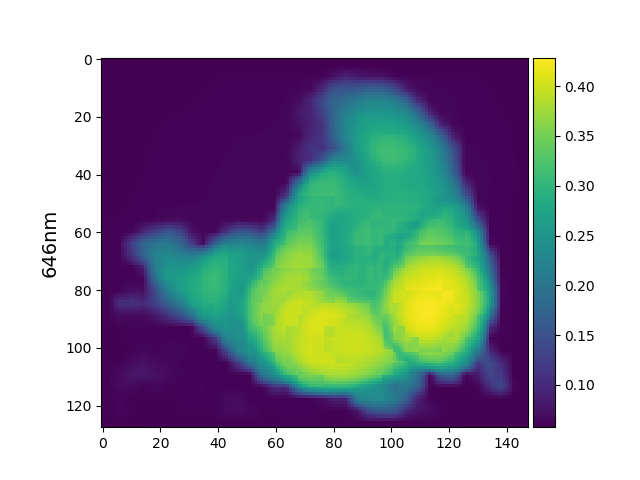

<IPython.core.display.Javascript object>


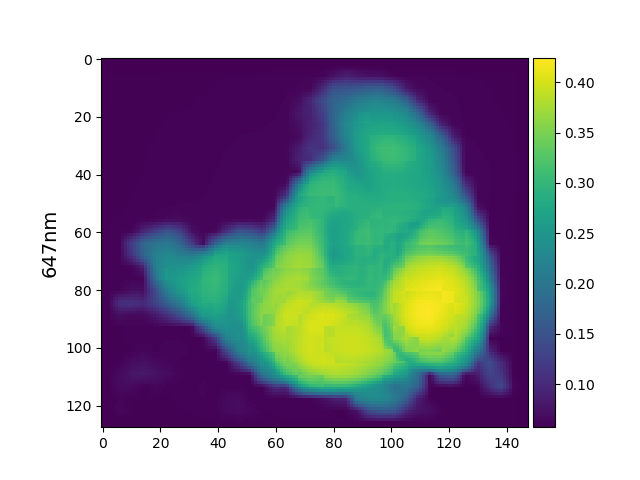

<IPython.core.display.Javascript object>


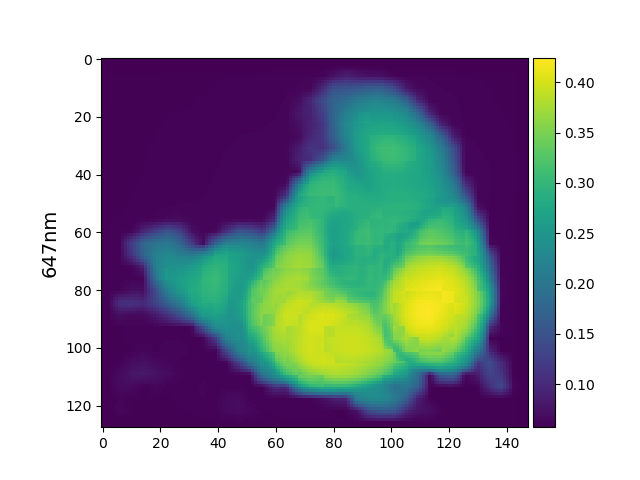

<IPython.core.display.Javascript object>


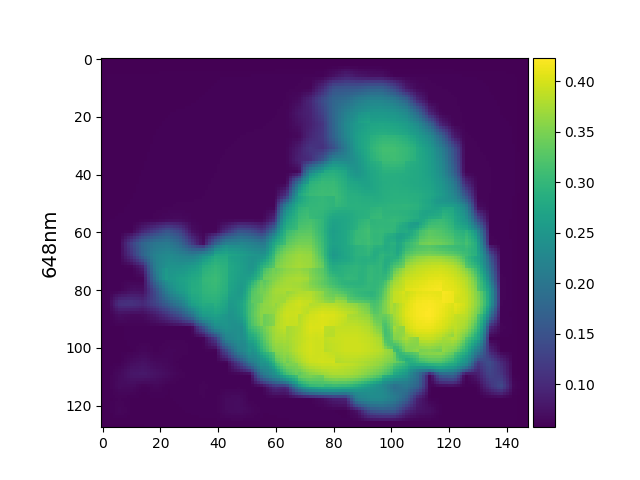

<IPython.core.display.Javascript object>


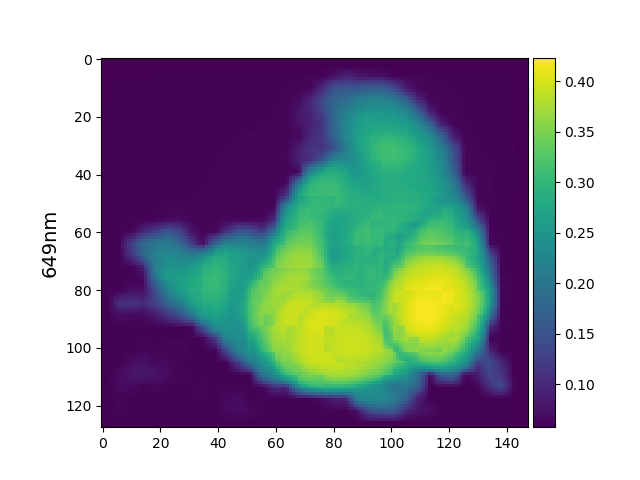

<IPython.core.display.Javascript object>


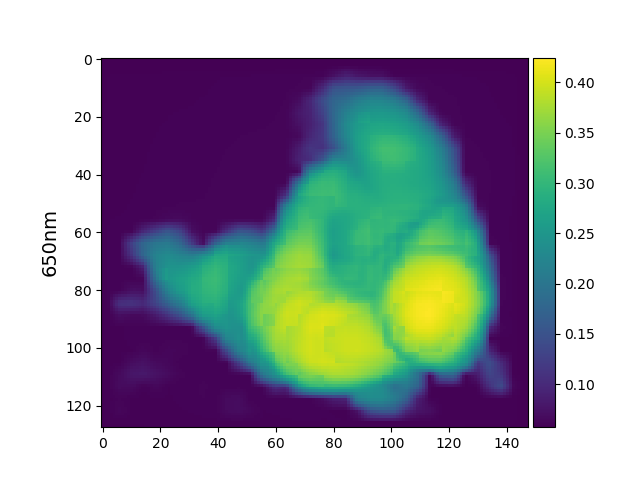

/home/vhold/anaconda3/envs/pyshdom/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


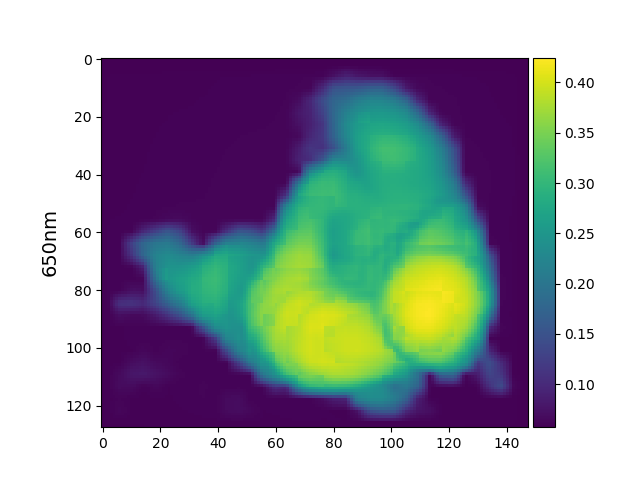

<IPython.core.display.Javascript object>


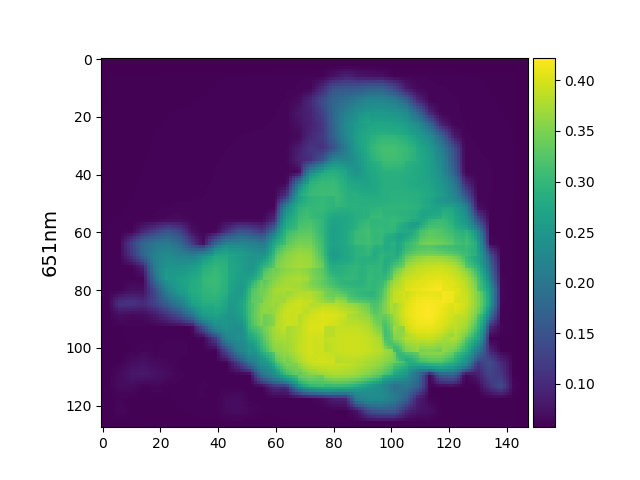

<IPython.core.display.Javascript object>


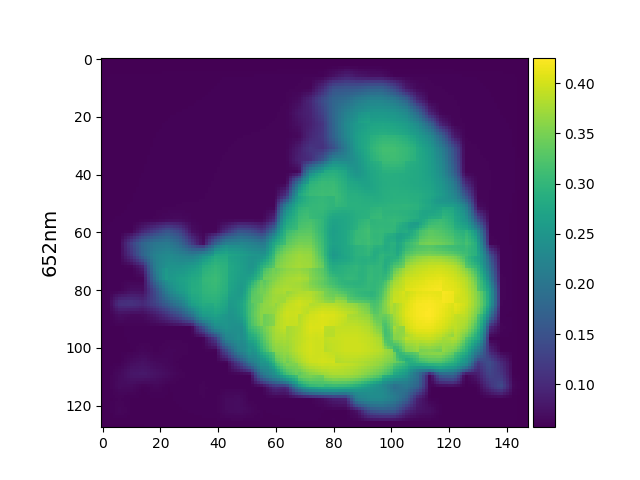

<IPython.core.display.Javascript object>


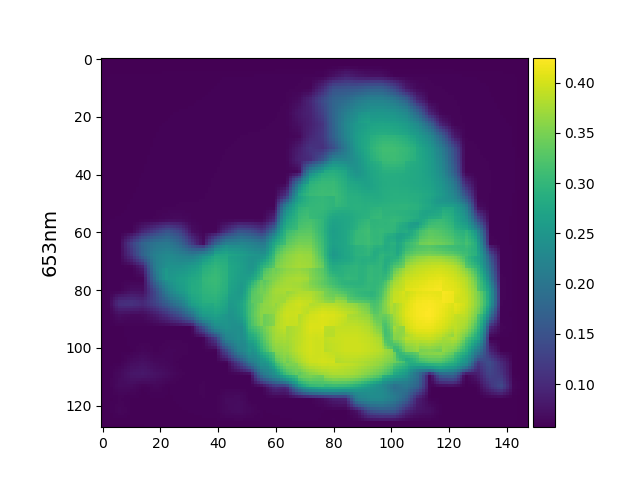

<IPython.core.display.Javascript object>


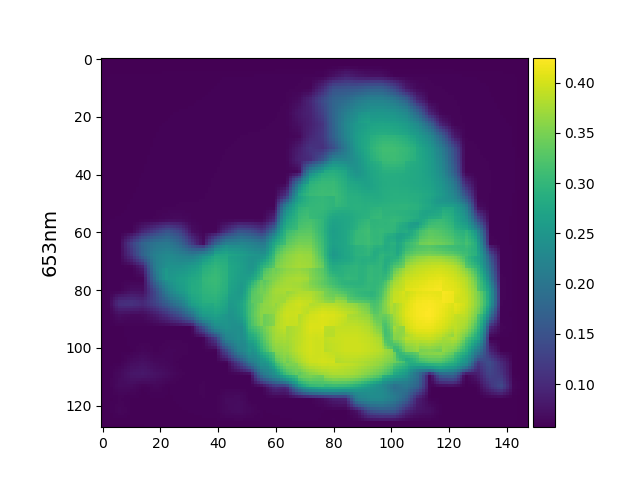

<IPython.core.display.Javascript object>


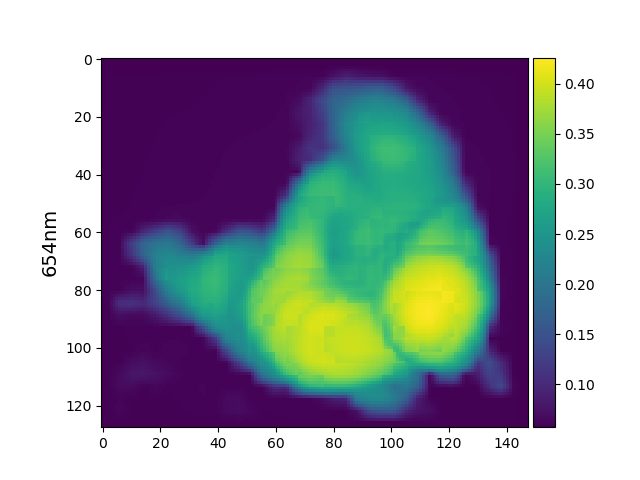

<IPython.core.display.Javascript object>


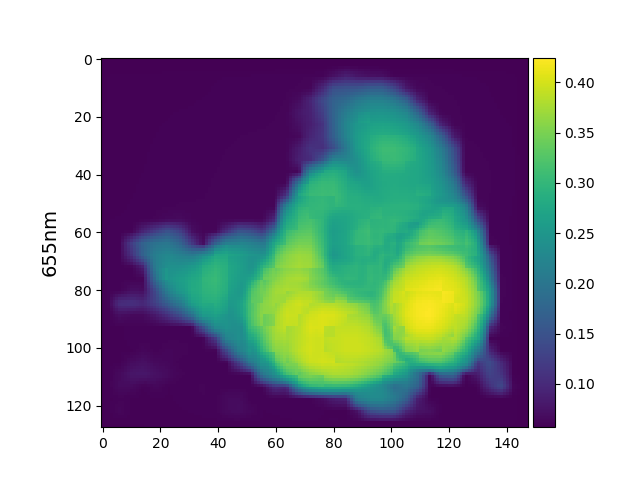

<IPython.core.display.Javascript object>


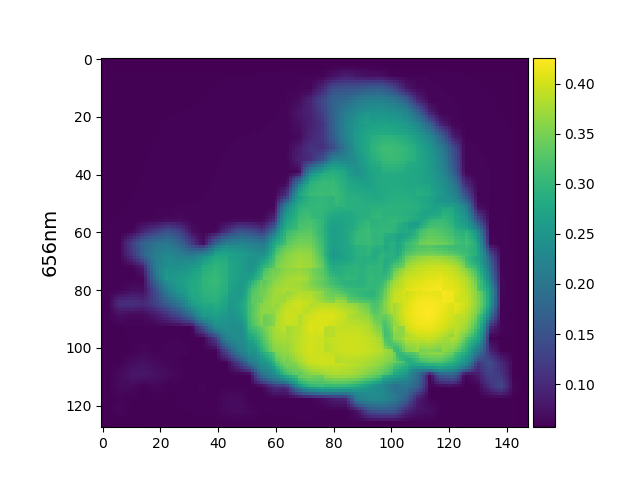

<IPython.core.display.Javascript object>


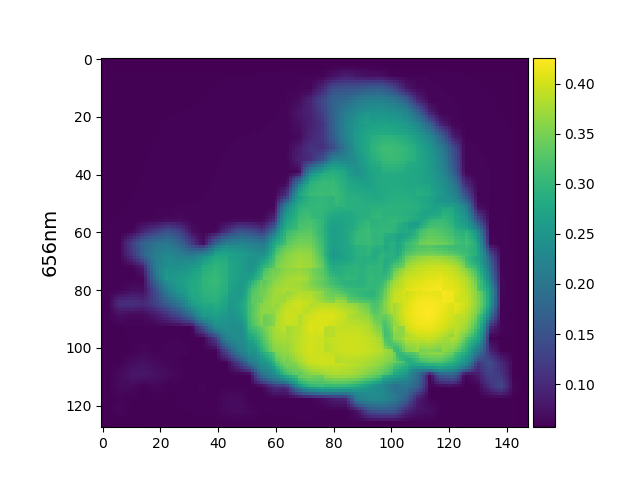

<IPython.core.display.Javascript object>


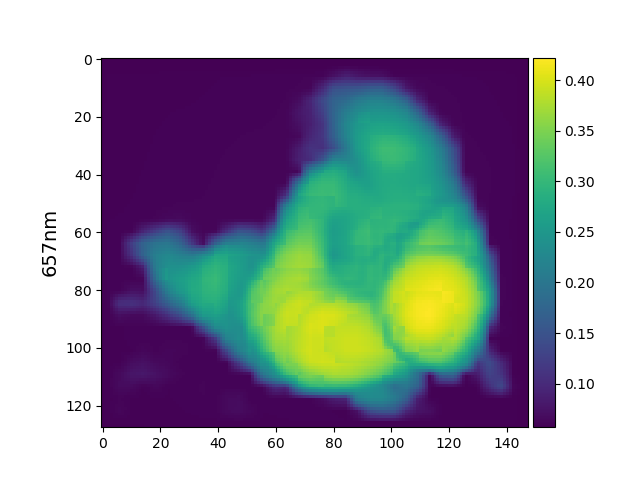

<IPython.core.display.Javascript object>


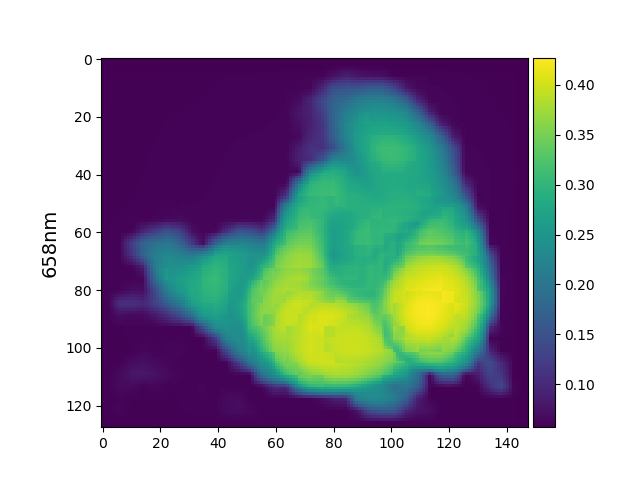

<IPython.core.display.Javascript object>


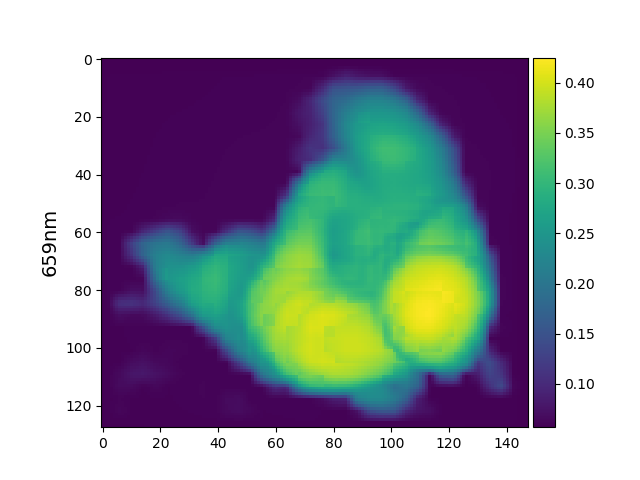

<IPython.core.display.Javascript object>


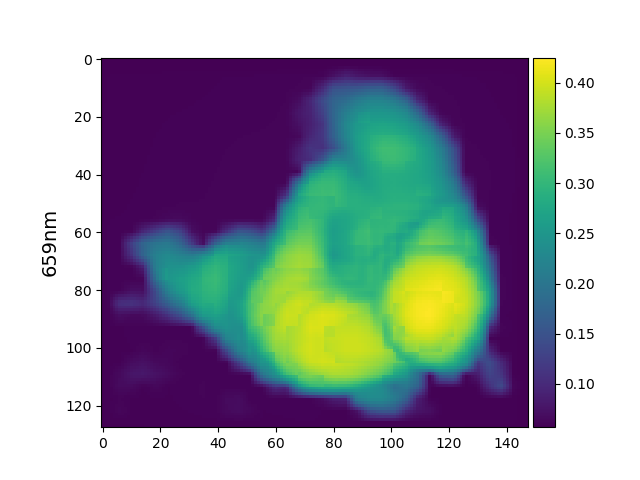

<IPython.core.display.Javascript object>


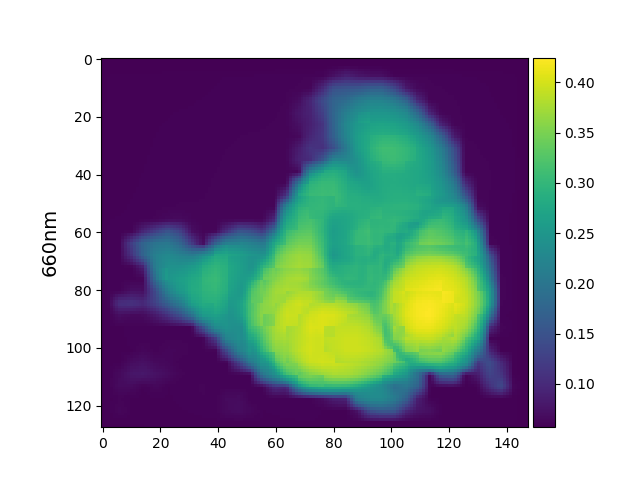

In [181]:
# integrated_image = 
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable


fontsize = 14

grid = AxesGrid(fig, 111,
                nrows_ncols=(integration_samples, 1),
                axes_pad=0.1,share_all=True,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.8
                )
ax_ind = 0

grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
    
title = 'cloud albedo'

for img_inx, (central_wavelength,scale_solar_flux) in enumerate(zip(wavelength_integration_samples,scale_solar_fluxs)):
    central_wavelength = shdom.float_round(central_wavelength)
    
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(np.pi*images[:,:,img_inx])
    ax.set_ylabel('{}nm'.format(int(1e3*central_wavelength)),rotation=90, fontsize=fontsize)

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)

    

In [138]:
(dw*1e3)

10.0

In [139]:
dw

0.01